# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 3.5. Трансформеры для Named Entity Recognition`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__27 марта 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__06 апреля 05:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий)

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В рамках этого задания вы научитесь:
1. Загружать датасеты и претренированные модели из [Hugging face Hub](https://huggingface.co)
2. Манипулировать текстовыми датасетами с помощью библиотеки [datasets](https://huggingface.co/docs/datasets/index)
3. Запускать и обучать трансформеры с помощью библиотеки [transformers](https://huggingface.co/docs/transformers/index)
4. Промптить большую языковую модель на примере [Qwen2.5-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct)
5. Оптимизировать гиперпараметры с помощью библиотеки [optuna](https://optuna.org/)

При выполнении задания вы будете решать стандартную задачу классификации токенов: распознавание именованных сущностей.

Задание состоит из трёх частей:
1. Обработка данных и работа с датасетами из Hugging Face.
2. Практика больших языковых моделей.
3. Дообучение трансформера.

Обратите свое внимание на [официальный гайд](https://huggingface.co/learn/nlp-course/chapter7/2), в котором подробно разбирается задача классификации токенов.

## `Часть 1. Загрузка и предобработка (4 балла)`

### `Подготовка среды Kaggle`

**Хранение ключей**: Kaggle Secrets --- инструмент для безопасного хранения и использования в ноутбуках Kaggle API-ключей, паролей или токенов.

Для добавления нового ключа:
1. Перейдите в Add-ons --> secrets
2. Add secret для добавления нового ключа. Доступ к ключу из ноутбука осуществляется с помощью пакета kaggle_secrets
3. Коллекция ключей общая для всех ноутбуков пользователя на kaggle. Но в каждом ноутбуке необходимо выбрать ключи, которые будут доступны через kaggle_secrets

Ниже находится пример подгрузки ключей для kaggle и wandb.

In [1]:
from kaggle_secrets import UserSecretsClient
import os

api_keys = UserSecretsClient()

os.system(f"huggingface-cli login --token {api_keys.get_secret('huggingface-cli')}")
os.system(f"wandb login {api_keys.get_secret('wandb')}")

0

**Установка домашнего каталога**: Если мы хотим контролировать путь, по которому будут загружаться датасеты, чекпоинты моделей и т.д., то стоит задать переменную среды `HF_HOME`. При использовании kaggle перемещение домашнего каталога huggingface в директорию working позволит избежать повторной загрузки при перезапуске ноутбука (не забудьте установить "persistence: files only" в настройках kaggle-ноутбука)

In [2]:
# Optional

os.environ['HF_HOME'] = '/kaggle/working/hf_hub'

### `Подготовка среды Google Colab`

Секреты можно настроить в колабе:

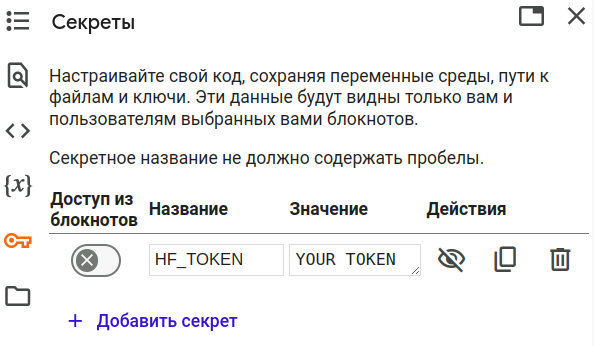

### `Общая подготовка`

In [3]:
# pip offers the --quiet / -q option to silence output

! pip install transformers[torch] datasets autoawq evaluate seqeval optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 MB 10.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 95.8 MB/s eta 0:00:00:00:01


При работе с библиотеками часто бывает важно соблюдение версий. Задание тестировалось на Python 3.12 при версиях библиотек указанных ниже.

In [4]:
!pip freeze > requirements.txt
!cat requirements.txt | grep torch

pytorch-ignite==0.5.1
pytorch-lightning==2.5.0.post0
torch @ https://download.pytorch.org/whl/cu121_full/torch-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchinfo==1.8.0
torchmetrics==1.6.1
torchsummary==1.5.1
torchtune==0.5.0
torchvision @ https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-linux_x86_64.whl


In [5]:
!cat requirements.txt | grep transformers
!cat requirements.txt | grep datasets
!cat requirements.txt | grep autoawq
!cat requirements.txt | grep evaluate
!cat requirements.txt | grep seqeval
!cat requirements.txt | grep optuna

sentence-transformers==3.3.1
transformers==4.47.0
datasets==3.3.1
tensorflow-datasets==4.9.7
vega-datasets==0.9.0
autoawq==0.2.8
evaluate==0.4.3
seqeval==1.2.2
optuna==4.2.1


In [6]:
import gc
import json
import random
from typing import Any, Union
from pathlib import Path

import numpy as np
import numpy.typing as npt

import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TextGenerationPipeline,
    pipeline,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from transformers.trainer_callback import EarlyStoppingCallback

import optuna
import evaluate

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

In [7]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

set_global_seed(42)

На протяжении всего задания вы можете добавлять любой `import`, иногда, это и являются частью задания. При работе с большими библиотеками очень важно уметь читать документацию и использовать гугл для поиска информации.

Для выполнения задания необходимо использование GPU!

In [8]:
if not torch.cuda.is_available():
    print("You need GPU!!!")

### `Загрузка данных (0.25 балла)`

В первую очередь, Hugging Face --- это хаб с датасетами и моделями. Загрузите готовый датасет [отсюда](https://huggingface.co/datasets/voorhs/conll2003-corrupted).

Подсказка: почитайте [туториал](https://huggingface.co/docs/datasets/load_hub).

*Если не получится сразу, то лучше перед следующими попытками перезапустить ноутбук.*

In [9]:
data = datasets.load_dataset("voorhs/conll2003-corrupted")

README.md:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

**Вопрос**: Какие поля нам доступны? Напечатайте пару примеров из каждого сплита. Попытайтесь догадаться какой смысл имеет каждое поле и опишите в двух словах.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/access).

In [10]:
print(f"Train split:\n{data['train'][:2]}\n")
print(f"Validation split:\n{data['validation'][:2]}\n")
print(f"Test split:\n{data['test'][:2]}")

Train split:
{'id': ['473', '8848'], 'tokens': [['LONDON', '1996-08-22'], ['WorldCom', ',', 'which', 'said', 'it', 'will', 'buy', 'MFS', ',', 'shed', '1-3/4', 'to', 'close', 'at', '21', 'while', 'MFS', 'lost', '3-8/16', 'to', 'close', 'at', '41-5/16', '.']], 'pos_tags': [[22, 11], [21, 6, 43, 38, 28, 20, 37, 22, 6, 38, 11, 35, 37, 15, 11, 15, 22, 38, 11, 35, 37, 15, 11, 7]], 'chunk_tags': [[11, 12], [11, 0, 11, 21, 11, 21, 22, 11, 0, 21, 11, 21, 22, 13, 11, 17, 11, 21, 22, 22, 22, 13, 3, 0]], 'ner_tags': [['B-LOC', 'O'], ['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]}

Validation split:
{'id': ['0', '1'], 'tokens': [['CRICKET', '-', 'LEICESTERSHIRE', 'TAKE', 'OVER', 'AT', 'TOP', 'AFTER', 'INNINGS', 'VICTORY', '.'], ['LONDON', '1996-08-30']], 'pos_tags': [[22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7], [22, 11]], 'chunk_tags': [[11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0], [11, 12]], 'ner_tags': [['O', 'O',

**Ответ:** **tokens** - последовательность слов, **pos_tags** - теги слов (различные слова - различные теги), **chunk_tags** - тег части речи, **ner_tags** - тег сущности.

### `Удаление колонок (0.25 балла)`

Мы будем предсказывать NER tags непосредственно по тексту. Остальная информация нам не понадобится. Удалите все колонки кроме `tokens` и `ner_tags`.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/process#remove).

In [11]:
data = data.select_columns(['tokens', 'ner_tags'])

data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

### `Сбор тегов (0.25 балла)`

Обратите внимание,что в датасете представлена **BIO-разметка**.

**BIO-разметка** -- это способ аннотации текста для распознавания именованных сущностей (NER), где **B** (Beginning) обозначает начало сущности, **I** (Inside) — продолжение той же сущности, а **O** (Outside) — отсутствие сущности.

Например, в предложении *"Apple выпустила новый iPhone"* разметка будет: *"Apple/B-ORG выпустила/O новый/O iPhone/B-PRODUCT"*.

В предложении  *"Билл Гейтс основал Microsoft"* -- *"Билл/B-PER Гейтс/I-PER основал/O Microsoft/B-ORG"*.

**Такой формат помогает моделям точно определять границы и типы сущностей.**



Прежде чем работать с датасетом, необходимо понять, какие именно NER-теги присутствуют в данных. Напечатайте все уникальные значения NER-тегов, которые встречаются в датасете.

*Подсказка:* по датасету можно итерироваться с помощью конструкции `for ... in`

**Вопрос:**
- есть ли какие-то подозрительные теги, которых быть не должно?

In [12]:
tags = set()
for tag_row in data['train']['ner_tags']:
    tags.update(tag_row)

print(tags)

{'B-PER', 'I-PER', 'I-ORG', 'O', 'I-LOC', 'B-ORG', 'I-MISC', 'B-MISC', 'B-LOC', 'MISSING'}


**Ответ:** Есть. Тег 'MISSING' - пропущенные значения, вероятно.

Для вычисления лосс функции и подсчета метрик нам потребуется перевести теги в классы, так как мы будем решать задачу классификации.

Создайте мапинги тегов:
- `label2id`: строковое представление тега (например `B-PER`) -> индекс класса
- `id2label`: наоборот

Исключите из них подозрительные теги, которых не должно быть.

*Подсказка:* должно получиться 9 тегов

In [13]:
tags.remove('MISSING')
id2label = sorted(list(tags))

id2label

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [14]:
label2id = {name: i for i, name in enumerate(id2label)}
label2id

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'I-LOC': 4,
 'I-MISC': 5,
 'I-ORG': 6,
 'I-PER': 7,
 'O': 8}

### `Фильтрация (0.25 балла)`

В обучающей выборке для части объектов пропущена разметка. Разделите обучающую выборку на размеченные и неразмеченные объекты. Напечатайте размеры обеих частей.

*Подсказка:* прочитайте [туториал](https://huggingface.co/docs/datasets/process#select-and-filter). Фильрацию датасета можно написать в одну строчку.

In [15]:
dataset_raw_essential = datasets.DatasetDict()

dataset_raw_essential["train_missing"] = data['train'].filter(lambda x: any([y == 'MISSING' for y in x['ner_tags']]))
dataset_raw_essential["train"] = data['train'].filter(lambda x: all([y != 'MISSING' for y in x['ner_tags']]))
dataset_raw_essential['validation'] = data['validation']
dataset_raw_essential['test'] = data['test']

dataset_raw_essential

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

DatasetDict({
    train_missing: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4041
    })
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [16]:
assert len(dataset_raw_essential["train_missing"]) == 4041

### `Получение tokenizer-independent представления (2 балла)`

Имеющаяся BIO-разметка построена для токенизатора, который нам, к сожалению, **не известен**. Необходимо построить tokenizer-independent представление нашего датасета.

**Восстановление текста**: Для каждого объекта датасета необходимо объединить токены из `tokens` в единую строку и поместить в поле `text`. Необходимо учесть, что знаки препинания, кавычки и скобки (например, `,`, `.`, `!`. `)`, `"`) не должны иметь пробелов перед собой, но должны иметь пробел после себя.

**Изменение BIO-разметки**: Так как каждый токенизатор по-своему разобьет полученный `text`, то необходимо уметь строить BIO-разметку для любого токенизатора.

По имеющейся BIO-разметке необходимо:
* Оставить только последовательность сущностей, удалив префиксы начала (B- и I-).
* Для каждой именованной сущности найти позиции символов, ей соответствующие (в формате python slice).

Пример результата:
```python
{
    'text': '6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)',
    'tags': ['PER', 'LOC', 'PER','LOC'],
    'ranges': [[4, 16], [19, 23], [30, 44], [47, 55]]
}
```

*Пояснение к примеру*. В тексте `'6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)'` встретилось четыре сущности:
- `PER` на позициях `[4,16]`, а именно `Andre Agassi`
- `LOC` на позициях `[19,23]`, а именно `U.S.`
- `PER` на позициях `[30,44]`, а именно `Mauricio Hadad`
- `LOC` на позициях `[47,55]`, а именно `Colombia`

**Важно:**
- Полученный результат сохраните на диск (например по пути `./data/generic`)
- Подробности о названиях аргументов и возвращаемых значениях берите из докстринга функции `transform_ner_data`

In [17]:
def transform_ner_data(tokens: list[str], ner_tags: list[str]):
    """
    Obtain tokenizer-independent representation of a single sample.

    Args:
        tokens: list of words, subwords or even punctuations
        ner_tags: list of BIO labels
    Returns:
        sample: dictionary with the following contents:
            - text (str): detokenized sequence
            - tags (list[str]): list of tags names (PER, ORG, LOC, MISC)
            - ranges (list[tuple[int, int]]): list of python slices for each entity
    """

    punctuation_symbols = ("-", "'", ".", ",", ")", ":", ";", '"')

    text = ""
    ranges = []
    tags = []
    
    # declare vars if you needed
    next_token = -1
    start_token = 0
    
    for token, tag in zip(tokens, ner_tags):
        # Adjust spacing based on token type
        if len(text) > 0 and not token.startswith(
            punctuation_symbols
        ):
            text += " "

        token_start = len(text)
        text += token

        # Handle entity tagging
        if tag.startswith("B-"):  # Begin a new entity
            start_token = token_start
            tags.append(tag[2:])
            next_token = len(text)
            
        elif tag.startswith("I-"):  # Continue an entity
            next_token = len(text)
            
        else:  # Tag is "O" or unrelated, close any open entity
            if next_token != -1:
                ranges.append([start_token, next_token])
                next_token = -1
    
    # Close any open entity at the end
    if next_token != -1:
        ranges.append([start_token, next_token])

    # Final output
    return {"text": text, "tags": tags, "ranges": ranges}

Проверьте, что все работает:

In [18]:
dataset_generic = dataset_raw_essential.map(
    function=transform_ner_data,
    input_columns=["tokens", "ner_tags"],
    remove_columns=dataset_raw_essential["train"].column_names,
)

dataset_generic

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
})

In [19]:
assert dataset_generic["train"][:3] == {
    "text": [
        "LONDON 1996-08-22",
        "WorldCom, which said it will buy MFS, shed 1-3/4 to close at 21 while MFS lost 3-8/16 to close at 41-5/16.",
        "6- Andre Agassi ( U.S.) vs. Mauricio Hadad ( Colombia)",
    ],
    "tags": [["LOC"], ["ORG", "ORG", "ORG"], ["PER", "LOC", "PER", "LOC"]],
    "ranges": [
        [[0, 6]],
        [[0, 8], [33, 36], [70, 73]],
        [[3, 15], [18, 22], [28, 42], [45, 53]],
    ],
}

Сохраните результат на диск (используйте функции из библиотеки `datasets`):

In [20]:
dataset_generic.save_to_disk("./data/generic")

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

### `Токенизация (1 балл)`

Для отладки воспользуемся токенизатором модели `google-bert/bert-base-uncased`.

In [21]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
print(bert_tokenizer(dataset_generic["train"]["text"][11]))

{'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


У каждого токенизатора есть свои специальные токены, для получения этой информации можно воспользоваться соотвествующей переменной.

In [23]:
bert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Теперь надо написать функцию, которая по имеющуемуся tokenizer-independent представлению выдает BIO-разметку для предоставленного токенизатора.  Реализуйте функцию `align_tokens_and_tags`, которая трансформирует один объект из датасета. Все подробности о формате входных данных берите из докстринга.

**Важно:** служебные токены, добавляемые токенизатором должны иметь специальный лейбл `SPECIAL_TOKENS_LABEL`, т.к. их не надо учитывать при сборе лосса.

In [24]:
SPECIAL_TOKENS_LABEL = -100


def align_tokens_and_tags(
    text: str, tags: list[str], ranges: list[tuple[int, int]], tokenizer: AutoTokenizer
):
    """
    Align the tokenizer-independent representation with a Hugging Face tokenizer.

    Args:
        text: original text.
        tags: list of entity tags (e.g., ["PER", "LOC"]).
        ranges: list of (start, end) character ranges for each entity.
        tokenizer: A Hugging Face tokenizer.

    Returns:
        dict: A dictionary with `input_ids`, `labels`:
            - input_ids are tokens indices in tokenizer's vocabulary
            - labels are integer labels for BIO tags (from label2id mapping)

    Note:
        This function
    """
    encoding = tokenizer(
        text, return_offsets_mapping=True, truncation=True, padding=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    token_ids = encoding["input_ids"]
    offset_mapping = encoding["offset_mapping"]

    labels = []
    # Initialize BIO tags for each token
    for token in token_ids:
        if token in tokenizer.all_special_ids:
            labels.append(SPECIAL_TOKENS_LABEL)
        else:
            labels.append("O")
    open_flag = False
    
    # Map character ranges to token indices
    for tag, (start, end) in zip(tags, ranges):
        # Find tokens that overlap with the entity range
        for (i, (token_start, token_end)), token_id in zip(
            enumerate(offset_mapping), token_ids
        ):
            
            # detect no overlap
            if labels[i] == SPECIAL_TOKENS_LABEL or token_start >= end or token_end <= start:
                continue
            
            # classifier token 
            #     hint: use if
            if open_flag:
                labels[i] = f"I-{tag}"
            else:
                labels[i] = f"B-{tag}"
                open_flag = True
                
        open_flag = False
            
    return {
        "input_ids": token_ids,
        "labels": [label2id.get(label, SPECIAL_TOKENS_LABEL) for label in labels] # don't forget to handle special tokens
    }

In [25]:
def tokenize_ner_dataset(
    dataset: Union[datasets.DatasetDict, datasets.Dataset], tokenizer: AutoTokenizer
):
    return dataset.map(
        function=align_tokens_and_tags,
        input_columns=["text", "tags", "ranges"],
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=(
            dataset["train"] if "train" in dataset else dataset
        ).column_names,
    )

Вот пара примеров того, что должно получиться:

In [26]:
for i in range(9, 12):
    sample = dataset_generic["train"][i]
    print("before tokenization:", sample)
    tokenized_sample = align_tokens_and_tags(**sample, tokenizer=bert_tokenizer)
    print("after tokenization:", tokenized_sample)
    print()

before tokenization: {'text': '1-0.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 1015, 1011, 1014, 1012, 102], 'labels': [-100, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Puchon 3 Chonan 0 ( halftime 1-0)', 'tags': ['ORG', 'ORG'], 'ranges': [[0, 6], [9, 15]]}
after tokenization: {'input_ids': [101, 16405, 24561, 1017, 16480, 7229, 1014, 1006, 22589, 1015, 1011, 1014, 1007, 102], 'labels': [-100, 2, 6, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Primary iron output was 297,700 tonnes, 14.5 percent more than last July and 0.1 percent more than in June.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'labels': [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100]}



Тесты:

In [27]:
dataset_tokenized = tokenize_ner_dataset(dataset_generic, bert_tokenizer)

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [28]:
assert dataset_tokenized["train"][5:7] == {
    "input_ids": [
        [
            101,
            2002,
            2596,
            2000,
            2031,
            2042,
            2730,
            2006,
            9857,
            2305,
            1010,
            6114,
            2012,
            2560,
            2809,
            17079,
            8710,
            1012,
            102,
        ],
        [
            101,
            1023,
            1012,
            13093,
            6178,
            25185,
            1006,
            5706,
            1007,
            8902,
            4877,
            13181,
            2361,
            3590,
            102,
        ],
    ],
    "labels": [
        [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100],
        [-100, 8, 8, 3, 7, 7, 8, 0, 8, 2, 6, 6, 6, 8, -100],
    ],
}

## `Часть 2. Доразметка с помощью LLM (2 балла)`

Наконец, обратимся к трансфомерам! Причем сразу к большим.

Мы воспользуемся моделью `Qwen2.5` на 7 миллиардов параметров. Посмотреть актуальный лидерборд различных LLM [можно тут](https://lmarena.ai/). Кроме того, во вкладке direct chat можно пообщаться с различными LLM бесплатно.

### `Промт инжиниринг`

Для удобства парсинга, мы будем просить LLM возвращать ответы сразу в формате `json` словаря.

Напишите промт, в котором перечислите и опишите поля словаря, которые вы хотите получать от LLM.

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

*Подсказка:* попросите LLM добавить в словарь отдельное поле `reasoning`, в которую она поместит рассуждения

In [29]:
def messages_maker(text: str) -> list[dict[str, str]]:
    """
    Creates a prompt for the LLM inference to generate NER labels.

    Args:
        text: The input text to be labeled.
    Returns:
        list: A list of messages formatted for the LLM inferemce.
    """
    system_message = (
        "You are an expert in Named Entity Recognition (NER). Your task is to analyze the given text and identify "
        "entities such as persons (PER), locations (LOC), organizations (ORG), and miscellaneous (MISC). "
        "You must return the results in a specific JSON format with the following fields: "
        "The 'reasoning' field should contain all your initial thoughts for solving NER task. "
        "The 'labels' field: A list of detected NER labels (ONLY PER, LOC, ORG, or MISC)."
        "The 'ranges' field: A list of string of each entity (e.g., 'Saint-Petersburg' for sentence 'I explain Saint-Petersburg' as LOC)."
        "The 'text' field: The original input text you processed."
        "Important: Follow the instructions precisely. Return ONLY the JSON response—no additional text or explanations."
        "Output the JSON response in a single line (no line breaks or pretty-printing). Use compact formatting."
        "Failure to comply will result in termination."
    )

    user_message = f"Please analyze the following text and generate the NER labels as described:\n\n{text}"

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
    ]

    return messages

Для обработки одного примера будем использовать функцию `generate_answer`.

**Важно:** чтобы понимать, как это работает, почитайте [туториал](https://huggingface.co/docs/transformers/main/en/conversations#textgenerationpipeline).

In [30]:
def generate_answer(generator: TextGenerationPipeline, query: str) -> str:
    chat = generator(messages_maker(query), max_new_tokens=1024)[0]["generated_text"]
    return chat[-1]["content"]

Эта функция отправляет текстовый запрос `query` большой языковой модели и возвращает ответ:

In [31]:
from transformers import pipeline


model_name = "Qwen/Qwen2.5-7B-Instruct-AWQ"

generator = pipeline(model=model_name, task="text-generation", device="cuda:0")
print(type(generator))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>


In [32]:
print_params_count(generator.model)

Информация о числе параметров модели: Qwen2ForCausalLM
Всего параметров: 		 1090199040
Всего обучаемых параметров: 	 1090199040



In [33]:
generate_answer(generator, "I live in London, but my father is from Germany.")

'{"text":"I live in London, but my father is from Germany.","ranges":["London","Germany"],"labels":["LOC","LOC"]}'

In [34]:
generate_answer(generator, "Can't wait the Oasis reunion.")

'{"reasoning":"The sentence contains a band name \'Oasis\' which falls under ORG category.","labels":["ORG"],"ranges":["Oasis"],"text":"Can\'t wait the Oasis reunion."}'

In [35]:
generate_answer(generator, "Check, please.")

'{"reasoning":"The text \'Check, please.\' does not contain any named entities such as persons, locations, organizations, or miscellaneous terms.","labels":[],"ranges":[],"text":"Check, please."}'

In [36]:
generate_answer(generator, "Сигма сигма боой сигма боой сигма бой.")

'{"reasoning":"The text contains only names of entities without clear context. \'Sigma\' could be a person\'s name or an organization, but it\'s not explicitly clear. No locations are mentioned.","labels":["MISC","MISC","MISC","MISC"],"ranges":["Sigma","sigma","боой","sigma"],"text":"Сигма сигма боой сигма боой сигма бой."}'

### `Валидация ответов LLM (0.5 балла)`

Ответы LLM не всегда точны. Часто она галлюцинирует или просто делает не то, о чем ее попросили. Поэтому для удобной автоматизации работы с LLM важно уметь валидировать ответы.

1. Проанализируйте ответы LLM из предыдущих ячеек с вызовом `generate_answer` и предположите какие ошибки может делать LLM при генерации ответа.

2. Напишите валидатор, которые будет проверять корректность ответа LLM.

**Вопросы:**
- Какие ошибки LLM можно простить?
- Приведите примеры ошибок (и валидных семплов) и продемонстрируйте работу вашего валидатора

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

In [37]:
def validate(answer: dict) -> None:
    """
    Validate answer from LLM.

    Args:
        answer: dictionary parsed from LLM output

    Raises:
        ValueError: if the answer is not valid
    """
    #    hint: raise ValueError(error message)
    for key in ['labels', 'ranges', 'text', 'reasoning']:
        if key not in answer.keys():
            raise ValueError(f"The key '{key}' isn't in keys of answer.")
            
    if not isinstance(answer['labels'], list):
        raise ValueError("The 'labels' isn't the list.")
        
    if not isinstance(answer['ranges'], list):
        raise ValueError("The 'ranges' isn't the list.")

    if not isinstance(answer['text'], str):
        raise ValueError("The 'text' isn't the str.")

    if not isinstance(answer['reasoning'], str):
        raise ValueError("The 'reasoning' isn't the str.")
        
    if len(answer['labels']) != len(answer['ranges']):
        raise ValueError("Count of ranges not equal count of labels.")
        
    for label in answer['labels']:
        if not isinstance(label, str):
            raise ValueError(f"The label '{label}' in field 'labels' isn't the str.")
        
        if label not in ['PER', 'LOC', 'ORG', 'MISC']:
            raise ValueError(f"Label '{label}' isn't in ['PER', 'LOC', 'ORG', 'MISC'].")
    
    for r in answer['ranges']:
        if not isinstance(r, str):
            raise ValueError(f"The range '{r}' in field 'ranges' isn't the str.")
        
        if answer['text'].find(r) == -1:
            raise ValueError(f"Range '{r}' don't exist in text.")

### `Обработка ответа LLM (1.5 балла)`

Напишите функцию `generate_ner_labeling`, которая для данного примера
- обращается к LLM чтобы получить разметку (с помощью функции `generate_answer`, определенной ранее)
- парсит ответ LLM в питоновский словарь (с помощью функции `parse`, см. ниже)
- валидирует словарь (с помощью функции `validate`, определенной ранее)
- делает `k_tries` попыток, пока LLM не выдаст валидный ответ

**Важно:** для простоты считайте что в одном тексте одна и та же сущность не повторяется (т.е. "i work at apple and eat an apple" нет в датасете).

*Подсказка:*
- пользуйтесь конструкцией `try except`

Уделите особое внимание следующему вопросу:
- как лучше всего получать `ranges`: просить LLM или пытаться сделать самому?

In [38]:
def parse(response: str) -> dict[str, Any]:
    """
    Parse LLM's response into dictionary.

    Returns:
        out: dictionary with the arbitrary keys
    """
    start_dict = response.find("{")
    end_dict   = len(response) - response[::-1].find("}") - 1
    return json.loads(response[start_dict : end_dict + 1])

In [39]:
def generate_ner_labeling(
    text: str, generator: TextGenerationPipeline, k_tries: int = 3
) -> dict:
    """
    Generates NER labeling for the given text using the provided LLM instance.

    Args:
        text: The input text to label.
        llm: The LLM instance for generating NER labels.
        k_tries: Maximum number of attempts to generate valid JSON.

    Returns:
        A dictionary containing 'text', 'tags', 'ranges', 'reasoning' if managed to generate valid samples,
            otherwise dict with 'tags', 'ranges', 'reasoning' are filled with None.
    """
    for _ in range(k_tries):
        try:
            response = generate_answer(generator, text)
            response = parse(response)
            validate(response)
            
            ranges = []
            for r in response['ranges']:
                start_index = response['text'].find(r)
                ranges.append((start_index, start_index + len(r)))
            response['ranges'] = ranges
            
            return response

        except (json.JSONDecodeError, ValueError) as e:
            print(
                f"Invalid JSON or validation error: {e}. Response: {response}. Retrying..."
            )
            continue

        finally:
            gc.collect()
            torch.cuda.empty_cache()
    
    result = {
        "text": text, 
        "tags": None,
        "ranges": None,
        "reasoning": None
    }
    print(f"Failed to generate valid NER labeling after {k_tries} attempts.")
    return result

Хороший результат должен выглядеть подобным образом:

In [40]:
generate_ner_labeling("I live in London but my dog Jack doesn't like it.", generator)

{'reasoning': 'Identifying entities from the text. London is a location, Jack is a name of a dog which falls under MISC.',
 'labels': ['LOC', 'MISC'],
 'ranges': [(10, 16), (28, 32)],
 'text': "I live in London but my dog Jack doesn't like it."}

Загрузите из памяти ранее рагруженный датасет в tokenizer-independent представлении.

In [41]:
dataset_generic = datasets.load_from_disk('./data/generic')

dataset_generic

DatasetDict({
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
})

Мы не можем полноценно разметить 4000+ примеров. Работа LLM на потребительском железе и особенно в облачных средах типа Google Colab и Kaggle очень медленная.

В качестве щадящего режима авторы задания предлагают сделать следующее: доразметить только 10 примеров в пределах от 15 до 30 символов.

In [42]:
subset_size = 10
min_chars = 15
max_chars = 30

dataset = dataset_generic['train_missing'].filter(lambda x: min_chars <= len(x["text"]) <= max_chars).shuffle().select(range(10))
dataset

Filter:   0%|          | 0/4041 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 10
})

Приступим к синтезированию!

In [43]:
synthetic = [generate_ner_labeling(sample["text"], generator) for sample in dataset]

Invalid JSON or validation error: The key 'reasoning' isn't in keys of answer.. Response: {'text': 'LONDON 1996-08-28', 'labels': ['LOC', 'MISC'], 'ranges': ['LONDON']}. Retrying...
Invalid JSON or validation error: The key 'reasoning' isn't in keys of answer.. Response: {'text': 'LONDON 1996-08-28', 'ranges': ['LONDON'], 'labels': ['LOC']}. Retrying...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Invalid JSON or validation error: The key 'reasoning' isn't in keys of answer.. Response: {'text': 'Gasoline 400 400-425 425', 'ranges': [], 'labels': []}. Retrying...
Invalid JSON or validation error: The key 'reasoning' isn't in keys of answer.. Response: {'text': 'Gasoline 400 400-425 425', 'ranges': [], 'labels': []}. Retrying...
Invalid JSON or validation error: The key 'reasoning' isn't in keys of answer.. Response: {'text': 'Year to December 31, 1996', 'ranges': [], 'labels': []}. Retrying...


Хороший результат должен быть примерно таким:

In [44]:
synthetic

[{'reasoning': "Analyzing the text for named entities. 'International' could be considered a location but without more context it's not specific. 'Reserves' and 'and' are general words.",
  'labels': ['LOC'],
  'ranges': [(0, 13)],
  'text': 'International reserves and'},
 {'text': 'MINNESOTA 65 65.500 12',
  'ranges': [(0, 9)],
  'labels': ['ORG'],
  'reasoning': 'MINNESOTA is identified as an organization name.'},
 {'reasoning': "The text contains 'LONDON', which is a location (LOC). The date '1996-08-28' does not contain any person, organization, or miscellaneous entities.",
  'labels': ['LOC'],
  'ranges': [(0, 6)],
  'text': 'LONDON 1996-08-28'},
 {'reasoning': 'No clear person names, location names, or organization names are present in the text. All words are related to quantities or types of fuel.',
  'labels': [],
  'ranges': [],
  'text': 'Gasoline 400 400-425 425'},
 {'text': '5. Olofsson, della Noce 93',
  'ranges': [(3, 11), (13, 23)],
  'labels': ['PER', 'PER'],
  'reasoni

Результат присоедините к трейновой части нашего `generic` датасета и сохраните результат в папке `generic-synthetic`.

**Важно:** не забудьте отфильтровать неудачные результаты генерации, если они есть (это про случаи когда `k_tries` исчерпались)

In [45]:
filtered_synthetic = [{'text': sample['text'], 'tags': sample['labels'], 'ranges': sample['ranges']} \
                      for sample in synthetic if sample['reasoning'] != None]

filtered_synthetic = datasets.Dataset.from_list(filtered_synthetic)

dataset_generic['train_synthetic'] = datasets.concatenate_datasets([dataset_generic['train'], filtered_synthetic])

dataset_generic.save_to_disk("./data/generic-synthetic")

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10010 [00:00<?, ? examples/s]

Дальше мы не будем использовать генератор, поэтому нам нужно освободить память. Код ниже удалит модельку из памяти:

In [46]:
del generator
gc.collect()
torch.cuda.empty_cache()

## `Часть 3. Дообучение модели (4 балла)`

Приступим к дообучению модели. Кажется, что наступает самая сложная часть? Действительно, нам предстоит реализовать следующее:
- подсчет лосс функции для каждого токена
- подсчет метрик точности классификации
- встроить это в цикл обучения
- настроить правильное логирование и сохранение чекпоинтов
- желательно подобрать гиперпараметры

На самом деле все просто! `transformers` позволяет реализовать это в два счета благодаря использованию следующих сущностей (все в списке это ссылки на документацию):
- автомодель `AutoModelForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification))
- библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index))
- класс `DataCollatorForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification))
- интеграция с `optuna` ([документация тут](https://optuna.org/))
- и самое главное, Trainer API в лице `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments))

### `Токенизация датасета (0.1 балла)`

Токенизируйте датасет с помощью токенизатора модели `BAAI/bge-small-en-v1.5` [документация тут](https://huggingface.co/BAAI/bge-small-en-v1.5) и ранее написанной функции `tokenize_ner_dataset`.

In [47]:
from transformers import AutoTokenizer

model_name = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Загрузите датасет с диска.

In [48]:
dataset_generic = datasets.load_from_disk('./data/generic-synthetic')

tokenized_dataset = tokenize_ner_dataset(dataset_generic, tokenizer)

tokenized_dataset

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/10010 [00:00<?, ? examples/s]

DatasetDict({
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
    train_synthetic: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10010
    })
})

### `Коллатор (0.1 балла)`

Инициализируйте коллатор и продемонстрируйте его работу.

In [49]:
collator = DataCollatorForTokenClassification(tokenizer)

In [50]:
batch = collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,    8,    8,    8,    8,    8, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100],
        [-100,    2,    6,    8,    8,    8,    8,    8,    8,    2,    6,    8,
            8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    2,
            6,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,
            8,    8,    8,    8, -100]])

### `Метрики (0.8 балла)`

Библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index)) предоставляет набор популярных метрик для NLP. Метрики для `NER` можно загрузить следующей командой:

In [51]:
import evaluate

metric = evaluate.load("seqeval")

Эта метрика работает с BIO разметкой в текстовом представлении:

In [52]:
metric.compute(
    predictions=[["O", "B-PER", "O", "O"]], references=[["O", "B-PER", "I-PER", "O"]]
)

{'PER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.75}

In [53]:
metric.compute(
    predictions=[["O", "B-PER", "B-ORG", "O"]],
    references=[["O", "B-PER", "I-PER", "B-ORG"]],
)

{'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'PER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.5}

Реализуйте функцию `compute_metrics`.

In [54]:
def compute_metrics(
    eval_preds: tuple[npt.NDArray, list[list[int]]],
) -> dict[str, float]:
    """
    Compute metrics on given batch.

    Args:
        eval_preds: tuple with the following contents:
            - logits: array of shape `(batch_size, seq_length, n_classes)`,
            - labels: list of lists, i.e. matrix of shape `(batch_size, seq_length)`
    Returns:
        metrics: dictionary with metrics calculated over all classes:
            - precision
            - recall
            - f1
            - accuracy
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    labels = np.array(labels)
    # Remove ignored index (special tokens) and convert to labels
    predictions = predictions[labels != -100].tolist()
    labels = labels[labels != -100].tolist()
    
    if isinstance(predictions[0], list):
        token_labels = [[id2label[label] for label in label_row] for label_row in labels]
        token_pred_labels = [[id2label[label] for label in label_row] for label_row in predictions]
    else:
        token_labels = [[id2label[label] for label in labels]]
        token_pred_labels = [[id2label[label] for label in predictions]]
    
    all_metrics = metric.compute(predictions=token_pred_labels, references=token_labels)

    return {
        "precision": all_metrics['overall_precision'],
        "recall": all_metrics['overall_recall'],
        "f1": all_metrics['overall_f1'],
        "accuracy": all_metrics['overall_accuracy'],
    }

### `Построение модели`

In [55]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обратите внимание на её структуру --- `transformers` автоматически добавил `classifier` с нужным числом классов:

In [56]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12

In [57]:
print_params_count(model)

Информация о числе параметров модели: BertForTokenClassification
Всего параметров: 		 33215625
Всего обучаемых параметров: 	 33215625



### `Обучение (1 балл)`

In [58]:
import wandb

wandb.login(key=api_keys.get_secret('wandb'))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: s02220164 (s02220164-m-v-lomonosovmoscow-state-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Ниже представлен базовый код для обучения модели:

In [59]:
from transformers import TrainingArguments

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01
)

In [60]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [61]:
trainer.train()

wandb.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.491800,0.198787,0.738908,0.785012,0.761263,0.956440
2,0.197900,0.144275,0.820922,0.863513,0.841679,0.969514
3,0.150500,0.130690,0.832424,0.879281,0.855211,0.971643


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▂▄▅▆██
train/global_step,▁▂▄▅▆██
train/grad_norm,█▁▁


Благодаря простому интерфейсу обучения разработчик может сместить фокус своих усилий с написания трейн лупа на решение более высокоуровневых задач.

Модифицируйте `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments`([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)) следующим образом:
- должно происходить логирование в `wandb`
- должен срабатывать ранний останов обучения, если качество перестало расти (подберите параметры на ваше усмотрение)
- лучший чекпоинт загружается в публичный репозиторий на `hugging face hub`

Добавьте в ячейку ниже ссылку на свой `wandb` отчет и ссылку на свой репозиторий `hugging face hub`.

- **Отчет wandb**: *https://wandb.ai/s02220164-m-v-lomonosovmoscow-state-university/ner_mmp/runs/6kkr3ut4?nw=nwusers02220164*
- **Репозиторий hf**: *https://huggingface.co/Gamcher/mmp_ner_3*

In [62]:
from huggingface_hub import login

login(api_keys.get_secret('huggingface-cli'))

In [63]:
from transformers import EarlyStoppingCallback

wandb.init(project="ner_mmp", name="ner_baseline")

args = TrainingArguments(
    output_dir='/data/bert-finetuned-ner',
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    greater_is_better=True, 
    save_total_limit=1,
    push_to_hub=True,
    hub_model_id="Gamcher/mmp_ner_3",
    hub_strategy="checkpoint",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="wandb",
    run_name="ner_baseline"
)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    callbacks=[early_stopping]
)

trainer.train()
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.108000,0.113672,0.834227,0.896745,0.864357,0.971976
2,0.078700,0.100673,0.862443,0.902509,0.882022,0.975551
3,0.067100,0.098531,0.860495,0.901492,0.880517,0.975821


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: dec48e64-048d-47f8-abea-8232ad41f7af)')' thrown while requesting PUT https://hf-hub-lfs-us-east-1.s3-accelerate.amazonaws.com/repos/00/9c/009c4e4a467814e1d99e8b19bc087d576d02f3044d4db78353149a1fd52cfbd7

eval/accuracy,▁██
eval/f1,▁█▇
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁█▇
eval/runtime,▂▁█
eval/samples_per_second,▇█▁
eval/steps_per_second,▇█▁
train/epoch,▁▂▄▅▆██
train/global_step,▁▂▄▅▆██
train/grad_norm,▂▁█


### `Перебор гиперпараметров (1 балл)`

Trainer API обладает интеграцией с `optuna` -- инструментом для перебора гиперпараметров в машинном обучении. Реализуйте перебор следующих гиперпараметров:
- `learning_rate` от `1e-6` до `1e-4` в логарифмическом масштабе
- `per_device_train_batch_size` среди `[4, 8, 16, 32]`

Учтите что поиск гиперпараметров лучше производить на маленькой порции трейна (возьмите 2048 случайных примеров), а метрику лучше считать на маленькой порции валидации (возьмите 512 случайных примеров).

Подробный [туториал](https://huggingface.co/docs/transformers/hpo_train).

In [64]:
from optuna import Trial

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float(
            "learning_rate", 1e-6, 1e-4, log=True
        ),
        "per_device_train_batch_size": trial.suggest_categorical(
            "per_device_train_batch_size", [4, 8, 16, 32]
        ),
    }

In [65]:
def model_init(trial: Trial):
    return AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )

In [66]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2048))
small_eval_dataset  = tokenized_dataset["validation"].shuffle(seed=42).select(range(512))

In [73]:
from transformers.trainer_callback import EarlyStoppingCallback

args = TrainingArguments(
    output_dir="data/bert-finetuned-ner",
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    save_strategy="epoch",
    metric_for_best_model="eval_f1",
    eval_strategy="epoch",
    load_best_model_at_end = True,
    greater_is_better=True,
    save_total_limit=1,
    report_to=None
)

trainer = Trainer(
    model=None,
    args=args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    model_init=model_init,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback()]
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

In [75]:
def compute_objective(eval_results: dict[str, float]) -> float:
    return eval_results["eval_f1"]

In [76]:
# time ~ 15 minutes

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
    sampler=sampler,
    compute_objective=compute_objective,
)

[I 2025-04-10 00:41:47,051] A new study created in memory with name: no-name-b3982233-7267-4f8a-ad95-8db01548a294
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.760907,0.000000,0.000000,0.000000,0.792655
2,0.927500,0.556878,0.328904,0.328177,0.328540,0.858057
3,0.927500,0.535462,0.355769,0.367956,0.361760,0.861770


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use

eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁█▆
eval/samples_per_second,█▁▃
eval/steps_per_second,█▁▃
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.627960,0.078947,0.003315,0.006363,0.790798
2,No log,1.191794,0.000000,0.000000,0.000000,0.792655


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 00:43:39,666] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 2.0511104188433975e-06, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.36175

eval/accuracy,▁█
eval/f1,█▁
eval/loss,█▁
eval/precision,█▁
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁██
train/global_step,▁██
eval/accuracy,0.79266


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.649598,0.071429,0.003315,0.006336,0.790489
2,1.712100,1.228668,0.000000,0.000000,0.000000,0.792655


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 00:44:33,655] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 1.0994335574766194e-06, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.36175

eval/accuracy,▁█
eval/f1,█▁
eval/loss,█▁
eval/precision,█▁
eval/recall,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁███
train/global_step,▁███
train/grad_norm,▁


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.531533,0.000000,0.000000,0.000000,0.791933
2,No log,1.080857,0.000000,0.000000,0.000000,0.792655


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 00:45:07,536] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 2.3270677083837795e-06, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.36175

eval/accuracy,▁█
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁██
train/global_step,▁██
eval/accuracy,0.79266


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.006157,0.000000,0.000000,0.000000,0.792655
2,No log,0.856069,0.000000,0.000000,0.000000,0.792655


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁██
train/global_step,▁██
eval/accuracy,0.79266


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.561008,0.318442,0.307182,0.312711,0.852796
2,No log,0.409707,0.380087,0.485083,0.426214,0.911079
3,No log,0.364448,0.482696,0.585635,0.529206,0.926037


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsq

eval/accuracy,▁▇█
eval/f1,▁▅█
eval/loss,█▃▁
eval/precision,▁▄█
eval/recall,▁▅█
eval/runtime,▁▃█
eval/samples_per_second,█▆▁
eval/steps_per_second,█▆▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.92604


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.016694,0.000000,0.000000,0.000000,0.792655
2,No log,0.859619,0.000000,0.000000,0.000000,0.792655


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.79266


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.541782,0.322722,0.324862,0.323789,0.855787
2,No log,0.379538,0.446333,0.551381,0.493327,0.922839
3,No log,0.335000,0.520677,0.612155,0.562722,0.932639


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/di

eval/accuracy,▁▇█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▅█
eval/recall,▁▇█
eval/runtime,▁█▅
eval/samples_per_second,█▁▄
eval/steps_per_second,█▁▄
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.93264


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.993351,0.021071,0.067403,0.032105,0.559212


[I 2025-04-10 00:47:11,445] Trial 8 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.55921


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.776348,0.000000,0.000000,0.000000,0.792655


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 00:47:26,850] Trial 9 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.79266


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.351602,0.495345,0.587845,0.537645,0.927068
2,No log,0.223999,0.693028,0.735912,0.713826,0.952548
3,No log,0.205505,0.711917,0.759116,0.734759,0.954198


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
[I 2025-04-10 00:48:00,326] 

eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▂█▁
eval/samples_per_second,▇▁█
eval/steps_per_second,▇▁█
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.9542


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.359095,0.479630,0.572376,0.521914,0.923664
2,No log,0.229969,0.691501,0.728177,0.709365,0.951104
3,No log,0.208390,0.706308,0.754696,0.729701,0.953786


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsq

eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁█▄
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95379


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.340024,0.522275,0.608840,0.562245,0.929544
2,No log,0.217768,0.707627,0.738122,0.722553,0.952754
3,No log,0.198376,0.731296,0.766851,0.748652,0.955127


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsq

eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95513


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.346026,0.491557,0.579006,0.531710,0.924489
2,No log,0.218770,0.701571,0.740331,0.720430,0.952548
3,No log,0.198810,0.728512,0.767956,0.747714,0.956571


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsq

eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▃█
eval/samples_per_second,█▆▁
eval/steps_per_second,█▆▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95657


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.480476,0.406402,0.462983,0.432851,0.879204


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 00:49:57,561] Trial 14 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.8792


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.423427,0.000000,0.000000,0.000000,0.792552


[I 2025-04-10 00:50:12,782] Trial 15 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.79255


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.212545,0.685594,0.720442,0.702586,0.950588
2,0.348400,0.159228,0.757360,0.824309,0.789418,0.964102
3,0.348400,0.147931,0.796663,0.844199,0.819742,0.967403


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
[I 2025-04-10 00:51:31,731] Trial 16 finished with value: 0.8197424892703863 and parameters: {'learning_rate': 5.6524599759245234e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8197424892703863.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-smal

eval/accuracy,▁▇█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▆█
eval/recall,▁▇█
eval/runtime,▁█▃
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.304971,0.569733,0.636464,0.601253,0.935630
2,0.472600,0.218130,0.693582,0.740331,0.716195,0.950794
3,0.472600,0.201781,0.712821,0.767956,0.739362,0.954611


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
[I 2025-04-10 00:52:49,348] 

eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.219206,0.679663,0.712707,0.695793,0.949247
2,0.357900,0.164405,0.755849,0.820994,0.787076,0.963070
3,0.357900,0.152510,0.781410,0.845304,0.812102,0.966680


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
[I 2025-04-10 00:54:07,540] 

eval/accuracy,▁▇█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▆█
eval/recall,▁▇█
eval/runtime,▂▁█
eval/samples_per_second,▇█▁
eval/steps_per_second,▇█▁
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.558821,0.322618,0.310497,0.316441,0.859810
2,0.768600,0.460865,0.365724,0.457459,0.406480,0.882711


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-10 00:55:00,925] Trial 19 pruned. 


Чтобы посмотреть лучшие гиперпараметры, достаточно обратиться к соответствующему атрибуту. У вас, скорее всего, будут другие результаты, но похожие.

In [77]:
best_trial.hyperparameters

{'learning_rate': 5.6524599759245234e-05, 'per_device_train_batch_size': 4}

Кроме того, мы можем посмотреть на значение метрики на лучшем запуске.

In [78]:
best_trial.objective

0.8197424892703863

### `Есть ли польза от доразметки (1 балл)`

Обучите NER модель с подобранными гиперпараметрами на датасете с доразмеченной частью и без. Дала ли доразметка значимый прирост? Прикрепите ссылку на wandb.

**Ссылка на wandb раны:** *https://wandb.ai/s02220164-m-v-lomonosovmoscow-state-university/ner_mmp?nw=nwusers02220164*

Обучим модель с лучшими параметрами, чтобы иметь бейзлайн с которым будем сравниваться.

In [84]:
args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
    report_to="wandb",
    run_name="ner_best_params"
)
model = AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
wandb.init(project="ner_mmp", name="ner_best_params")

trainer.train()

wandb.finish()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.159400,0.104036,0.856957,0.894880,0.875508,0.973692
2,0.079900,0.092821,0.873631,0.906070,0.889555,0.976599
3,0.052000,0.089115,0.886034,0.912174,0.898914,0.977696


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


eval/accuracy,▁▆█
eval/f1,▁▅█
eval/loss,█▃▁
eval/precision,▁▅█
eval/recall,▁▆█
eval/runtime,█▁█
eval/samples_per_second,▁█▁
eval/steps_per_second,▁█▁
train/epoch,▁▂▃▃▄▅▅▆▇██
train/global_step,▁▂▃▃▄▅▅▆▇██
train/grad_norm,▇▂▃█▆▃▁


Загрузим датасет с диска.

In [86]:
datasets.load_from_disk("./data/generic-synthetic")

DatasetDict({
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_synthetic: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10010
    })
})

Ваше мини исследование о том, как влияет доразметка на результаты обучения.

*Нет необходимости делать слишком много разных запусков, запустите обучение и сравните результаты*

**Без выводов пункт не будет засчитан**

In [87]:
args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
    report_to="wandb",
    run_name="ner_best_params_synthetic"
)
model = AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train_synthetic"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

wandb.init(project="ner_mmp", name="ner_best_params_synthetic")

trainer.train()

wandb.finish()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.154300,0.113800,0.868263,0.885046,0.876574,0.972564
2,0.080600,0.093034,0.890365,0.908783,0.899480,0.977282
3,0.049600,0.090273,0.890135,0.914886,0.902341,0.978188


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁█▅
eval/samples_per_second,█▁▄
eval/steps_per_second,█▁▄
train/epoch,▁▂▃▃▄▅▅▆▇██
train/global_step,▁▂▃▃▄▅▅▆▇██
train/grad_norm,▂█▁▁▁▁▁


**Ваши выводы:** Добавление синтетических данных увеличивает метрики при тех же гиперпараметрах, что означает - повышение качества модели при равных эпохах. Это связано с тем, что модель выучивает дополнительные данные, что приводит к лучшему результату (данных больше).

Мы очень будем рады, если здесь напишите ваше впечатление о задании!

*Обратная связь:* Отлично, но автозапуск wandb в kaggle мешает.


